# Generative Model (Olive Oils dataset)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.7


## Load raw data and plot

In [2]:
# read .csv file into Dataframe
data = pd.read_csv('../../data/olive_oils/FTIR_olive_oils.csv')
data.head(5)

,798.892,800.8215,802.751,804.6805,806.61,808.5395,810.469,812.3985,814.328,816.2575,...,1885.2305,1887.16,1889.0895,1891.019,1892.9485,1894.878,1896.8085,code,label,sample
0,0.127523,0.127950,0.129282,0.131174,0.133590,0.136426,0.139358,0.142219,0.144805,0.146764,...,0.012279,0.012158,0.011884,0.011716,0.011583,0.011315,0.011304,1,Greece,1
1,0.126498,0.127131,0.128511,0.130340,0.132527,0.135309,0.138353,0.141150,0.143630,0.145624,...,0.006467,0.006223,0.005720,0.005518,0.005494,0.005321,0.005426,1,Greece,1
2,0.130412,0.130675,0.132017,0.133824,0.136095,0.138944,0.141723,0.144136,0.146431,0.148389,...,0.007548,0.007391,0.007176,0.006843,0.006551,0.006398,0.006582,1,Greece,2
3,0.130022,0.130407,0.132018,0.134007,0.136271,0.138875,0.141481,0.144075,0.146553,0.148443,...,0.006059,0.005933,0.005507,0.005347,0.005349,0.005133,0.005222,1,Greece,2
4,0.128602,0.128790,0.130022,0.132012,0.134427,0.137070,0.139646,0.142338,0.144923,0.146958,...,0.010594,0.010379,0.010287,0.010127,0.009966,0.009760,0.009649,1,Greece,3


In [3]:
# shuffle data rows
data = data.sample(frac=1, random_state=42)

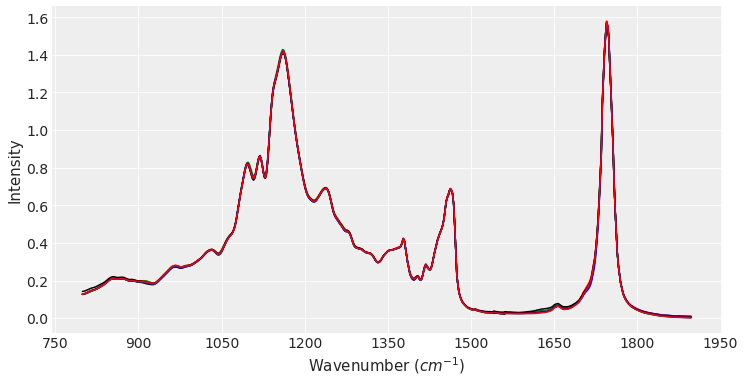

In [4]:
# number of non-data columns at right of dataframe
ndata_cols = -3

# index of column containing the class label
c_idx = -2

# class labels
clabels = ['Spain', 'Italy', 'Greece', 'Portugal']

# number of classes in data
nclass = len(clabels)

# header data = x-values
cols = data.columns.to_list()
x_val = np.array(cols[:ndata_cols], dtype='float32')

# plot all data in 1 figure
fig = plt.figure(figsize=(12,6))
ax = plt.axes()
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.set(xlabel='Wavenumber ($cm^{-1}$)', ylabel='Intensity')

for i in range(8):
    y_val = data.values[i]
    if y_val[c_idx] == clabels[0]:
        col = 'blue'
    elif y_val[c_idx] == clabels[1]:
        col = 'green'
    elif y_val[c_idx] == clabels[2]:
        col = 'red'
    elif y_val[c_idx] == clabels[3]:
        col = 'black'
    else:
        col = 'white'
    plt.plot(x_val, y_val[:ndata_cols], '-', color=col);

In [5]:
#data.describe()

In [6]:
# number of samples from each class
data['label'].value_counts()

Spain       50
Italy       34
Greece      20
Portugal    16
Name: label, dtype: int64

In [7]:
# store data values for class A and B
df_a = data.query("label == @clabels[0]")
df_b = data.query("label == @clabels[1]")
df_c = data.query("label == @clabels[2]")
df_d = data.query("label == @clabels[3]")

x_n = data.columns[:ndata_cols]

x_sa = df_a[x_n].values
x_sb = df_b[x_n].values
x_sc = df_c[x_n].values
x_sd = df_d[x_n].values

# Model definition

The following model is assumed:

\begin{equation}
\mu_{m} \sim \text{LogNormal}(0, 1) \\
\sigma_{ab} \sim \Gamma(1, 1) \\
\sigma_{m} \sim |\mathcal{N}(0, \sigma^{2}_{ab})| \\
\mu \sim \mathcal{N}(\mu_{m},\sigma^{2}_{m}) \\
\sigma_{\sigma} \sim \Gamma(1, 1) \\
\sigma \sim |\mathcal{N}(0, \sigma^{2}_{\sigma})| \\
X_{a..d} \sim \mathcal{N}(\mu,\sigma^{2})
\end{equation}

In [8]:
with pm.Model() as model_gm:
    
    mu_m = pm.Lognormal('mu_m', mu=0, sigma=1) 
    sigma_ab = pm.Gamma('sigma_ab', alpha=1., beta=1.)
    sigma_mu = pm.HalfNormal('sigma_mu', sigma_ab)
    mu = pm.Normal('mu', mu=mu_m, sd=sigma_mu, shape=(nclass,len(x_n)))
    
    sigma_s = pm.Gamma('sigma_s', alpha=1., beta=1.)
    sigma = pm.HalfNormal('sigma', sigma_s)
    
    class_a = pm.Normal('class_a', mu=mu[0], sd=sigma, observed=x_sa[:len(x_sa)])
    class_b = pm.Normal('class_b', mu=mu[1], sd=sigma, observed=x_sb[:len(x_sb)])
    class_c = pm.Normal('class_c', mu=mu[2], sd=sigma, observed=x_sc[:len(x_sc)])
    class_d = pm.Normal('class_d', mu=mu[3], sd=sigma, observed=x_sd[:len(x_sd)])
    
    trace_gm = pm.sample(2000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, sigma_s, mu, sigma_mu, sigma_ab, mu_m]
Sampling 2 chains: 100%|██████████| 5000/5000 [02:07<00:00, 39.11draws/s]


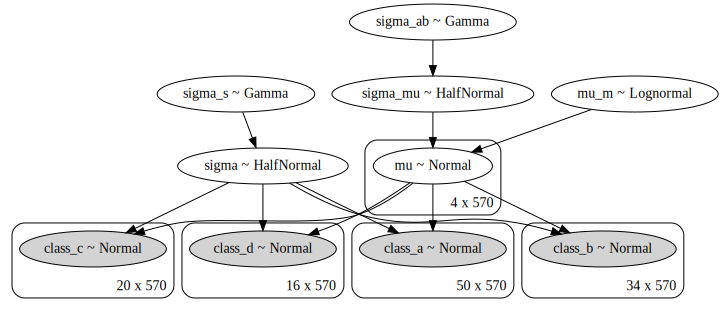

In [9]:
pm.model_to_graphviz(model_gm)

In [10]:
az.summary(trace_gm)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"mu[0,0]",0.127,0.000,0.126,0.128,0.000,0.000,4054.0,4053.0,4064.0,3049.0,1.0
"mu[0,1]",0.128,0.000,0.127,0.129,0.000,0.000,5600.0,5600.0,5602.0,2761.0,1.0
"mu[0,2]",0.129,0.000,0.128,0.130,0.000,0.000,3993.0,3992.0,4001.0,2618.0,1.0
"mu[0,3]",0.131,0.000,0.130,0.132,0.000,0.000,3859.0,3859.0,3874.0,2776.0,1.0
"mu[0,4]",0.134,0.000,0.133,0.134,0.000,0.000,3292.0,3291.0,3288.0,2449.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
mu_m,0.334,0.007,0.321,0.347,0.000,0.000,4599.0,4599.0,4595.0,2624.0,1.0
sigma_ab,0.762,0.632,0.111,1.858,0.012,0.008,2897.0,2796.0,4088.0,2467.0,1.0
sigma_mu,0.334,0.005,0.325,0.343,0.000,0.000,5091.0,5067.0,5113.0,2842.0,1.0
sigma_s,0.186,0.370,0.001,0.777,0.007,0.005,3153.0,3153.0,3759.0,3690.0,1.0


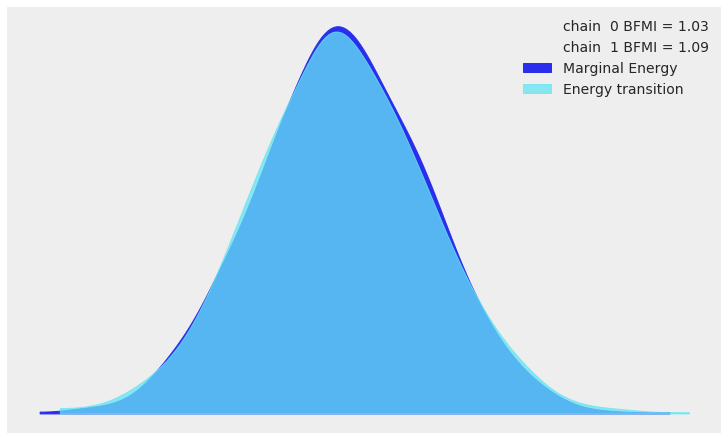

In [11]:
az.plot_energy(trace_gm, figsize=(10, 6));

In [12]:
ppc = pm.sample_posterior_predictive(trace_gm, samples=250, model=model_gm)

100%|██████████| 250/250 [00:02<00:00, 93.42it/s] 


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


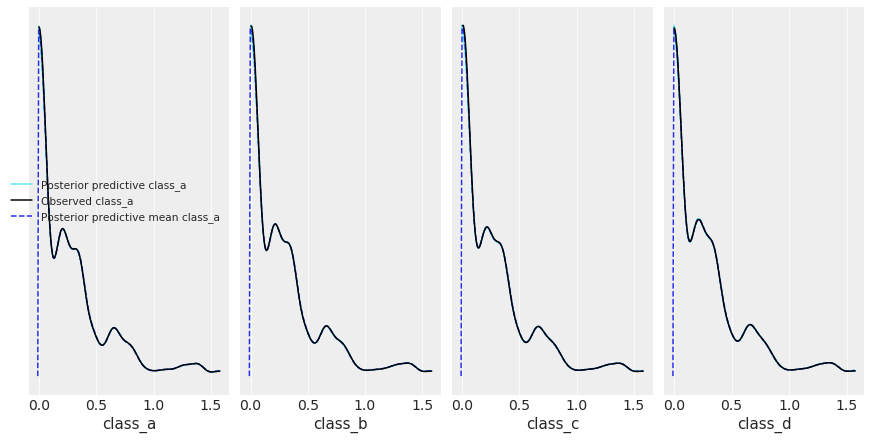

In [13]:
data_ppc = az.from_pymc3(trace=trace_gm, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

In [14]:
print(az.r2_score(x_sa[:len(x_sa)], ppc['class_a']))

r2        0.999917
r2_std    0.000007
dtype: float64


In [15]:
print(az.r2_score(x_sb[:len(x_sb)], ppc['class_b']))

r2        0.999916
r2_std    0.000007
dtype: float64


In [16]:
print(az.r2_score(x_sc[:len(x_sc)], ppc['class_c']))

r2        0.999914
r2_std    0.000008
dtype: float64


In [17]:
print(az.r2_score(x_sd[:len(x_sd)], ppc['class_d']))

r2        0.999912
r2_std    0.000008
dtype: float64


In [18]:
print(az.bfmi(trace_gm))

[1.02967378 1.08848728]


# Posterior samples vs. mean data

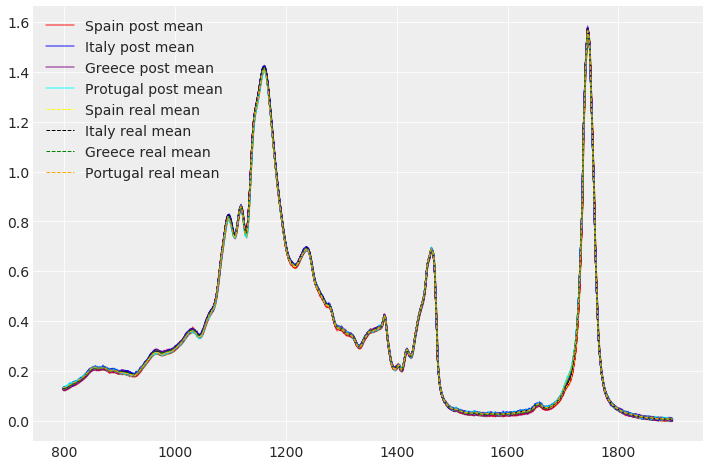

In [19]:
# draw class samples from the posterior
cl_a = ppc['class_a']
cl_b = ppc['class_b']
cl_c = ppc['class_c']
cl_d = ppc['class_d']

# get header data = x-values
cols = data.columns.to_list()
x_val = np.array(cols[:ndata_cols], dtype='float32')

fig = plt.figure(figsize=(12,8))
ax = plt.axes()

# plot some samples from the posterior
for i in range(10):
    plt.plot(x_val, cl_a[i,0,:], '-', color="red", alpha=.6)
    plt.plot(x_val, cl_b[i,0,:], '-', color="blue", alpha=.6)
    plt.plot(x_val, cl_c[i,0,:], '-', color="purple", alpha=.6)
    plt.plot(x_val, cl_d[i,0,:], '-', color="cyan", alpha=.6)

# plot the posterior mean
plt.plot(x_val, cl_a[:,0].mean(axis=0), '-', color="red", alpha=.6, 
         label='Spain post mean')
plt.plot(x_val, cl_b[:,0].mean(axis=0), '-', color="blue", alpha=.6, 
         label='Italy post mean')
plt.plot(x_val, cl_c[:,0].mean(axis=0), '-', color="purple", alpha=.6, 
         label='Greece post mean')
plt.plot(x_val, cl_d[:,0].mean(axis=0), '-', color="cyan", alpha=.6, 
         label='Protugal post mean')

# plot mean data for classes (raw data)
df1 = data.loc[data['label'] == clabels[0]]
df2 = data.loc[data['label'] == clabels[1]]
df3 = data.loc[data['label'] == clabels[2]]
df4 = data.loc[data['label'] == clabels[3]]

plt.plot(x_val, df1.iloc[:,:ndata_cols].mean(), '--', color='yellow', 
         label='Spain real mean', linewidth=1)
plt.plot(x_val, df2.iloc[:,:ndata_cols].mean(), '--', color='black', 
         label='Italy real mean', linewidth=1)
plt.plot(x_val, df3.iloc[:,:ndata_cols].mean(), '--', color='green', 
         label='Greece real mean', linewidth=1)
plt.plot(x_val, df4.iloc[:,:ndata_cols].mean(), '--', color='orange', 
         label='Portugal real mean', linewidth=1)

# plot 95% HPD interval
az.plot_hpd(x_val, ppc['class_a'], smooth=False, color='C1')
az.plot_hpd(x_val, ppc['class_b'], smooth=False, color='C2')
az.plot_hpd(x_val, ppc['class_c'], smooth=False, color='C3')
az.plot_hpd(x_val, ppc['class_d'], smooth=False, color='C4')

plt.legend(loc='best');

# Real spectrum vs. posterior samples

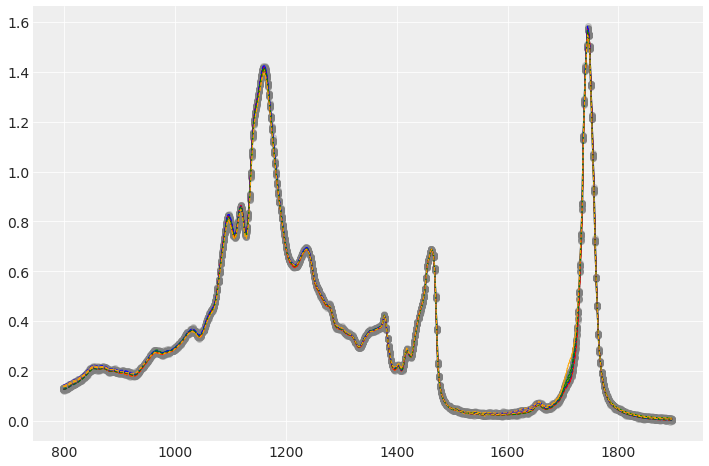

In [20]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes()

# plot some samples from the posterior
for i in range(5):
    plt.plot(x_val, cl_a[i,0,:], 'o-', color="gray", alpha=.3)
    plt.plot(x_val, cl_b[i,0,:], 'o-', color="gray", alpha=.3)
    plt.plot(x_val, cl_c[i,0,:], 'o-', color="gray", alpha=.3)
    plt.plot(x_val, cl_d[i,0,:], 'o-', color="gray", alpha=.3)

# plot mean data for classes (raw data)
df1 = data.loc[data['label'] == clabels[0]].sample(frac=1)
df2 = data.loc[data['label'] == clabels[1]].sample(frac=1)
df3 = data.loc[data['label'] == clabels[2]].sample(frac=1)
df4 = data.loc[data['label'] == clabels[3]].sample(frac=1)
    
for i in range(5):
    plt.plot(x_val, df1.values[i,:ndata_cols], '--', color='red', linewidth=1)
    plt.plot(x_val, df2.values[i,:ndata_cols], '--', color='blue', linewidth=1)
    plt.plot(x_val, df3.values[i,:ndata_cols], '--', color='green', linewidth=1)
    plt.plot(x_val, df4.values[i,:ndata_cols], '--', color='orange', linewidth=1)

# Save posterior samples to .csv file

In [21]:
import csv

samples_per_class = 50
filename = './ppc_samples_olive_oils.csv' 

# create header row
header = np.array(np.around(x_val, 3), dtype='str')
header = header.tolist()
header.append("label")

with open(filename, mode='w') as fp:
    ppc_writer = csv.writer(fp, delimiter=',')
    ppc_writer.writerow(header)
    
    for i in range(samples_per_class):
        row_a = np.array(cl_a[i,0,:], dtype='str').tolist()
        row_a.append(clabels[0])
        row_b = np.array(cl_b[i,0,:], dtype='str').tolist()
        row_b.append(clabels[1])
        row_c = np.array(cl_a[i,0,:], dtype='str').tolist()
        row_c.append(clabels[2])
        row_d = np.array(cl_b[i,0,:], dtype='str').tolist()
        row_d.append(clabels[3])
        ppc_writer.writerow(row_a)
        ppc_writer.writerow(row_b)
        ppc_writer.writerow(row_c)
        ppc_writer.writerow(row_d)